# Band Excitation data procesing using pycroscopy
### Suhas Somnath, Chris R. Smith, Stephen Jesse
The Center for Nanophase Materials Science and The Institute for Functional Imaging for Materials <br>
Oak Ridge National Laboratory<br>
2/10/2017

## Configure the notebook

In [1]:
# set up notebook to show plots within the notebook
% matplotlib inline

# Import necessary libraries:
# General utilities:
import sys
import os

# Computation:
import numpy as np
import h5py

# Visualization:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Finally, pycroscopy itself
sys.path.append('../../../')
import pycroscopy as px

## Set some basic parameters for computation
This notebook performs some functional fitting whose duration can be substantially decreased by using more memory and CPU cores. We have provided default values below but you may choose to change them if necessary.

In [2]:
max_mem         = 1024*8  # Maximum memory to use, in Mbs. Default = 1024
max_cores       = None    # Number of logical cores to use in fitting.  None uses all but 2 available cores.

## Make the data pycroscopy compatible
Converting the raw data into a pycroscopy compatible hierarchical data format (HDF or .h5) file gives you access to the fast fitting algorithms and powerful analysis functions within pycroscopy

#### H5 files:
* are like smart containers that can store matrices with data, folders to organize these datasets, images, metadata like experimental parameters, links or shortcuts to datasets, etc.
* are readily compatible with high-performance computing facilities
* scale very efficiently from few kilobytes to several terabytes
* can be read and modified using any language including Python, Matlab, C/C++, Java, Fortran, Igor Pro, etc.

#### You can load either of the following:
* Any .mat or .txt parameter file from the original experiment
* A .h5 file generated from the raw data using pycroscopy - skips translation

You can select desired file type by choosing the second option in the pull down menu on the bottom right of the file window

In [3]:
input_file_path = px.io_utils.uiGetFile(caption='Select translated .h5 file or raw experiment data',
                                  filter='Parameters for raw BE data (*.txt *.mat);; Translated file (*.h5)')

(data_dir, data_name) = os.path.split(input_file_path)

if input_file_path.endswith('.h5'):
    # No translation here
    h5_path = input_file_path
else:
    # Set the data to be translated
    data_path = input_file_path

    (junk, base_name) = os.path.split(data_dir)

    # Check if the data is in the new or old format.  Initialize the correct translator for the format.
    if base_name == 'newdataformat':
        (junk, base_name) = os.path.split(junk)
        # translator = tl.BEPSndfTranslator.BEPSndfTranslator(max_mem_mb=max_mem)
        translator = px.BEPSndfTranslator(max_mem_mb=max_mem)
    else:
        # translator = tl.BEodfTranslator.BEodfTranslator(max_mem_mb=max_mem)
        translator = px.BEodfTranslator(max_mem_mb=max_mem)
    if base_name.endswith('_d'):
        base_name = base_name[:-2]
    # Translate the data
    h5_path = translator.translate(data_path, show_plots=True, save_plots=False)
print('Working on:\n' + h5_path)

hdf = px.ioHDF5(h5_path)
h5_main = px.hdf_utils.getDataSet(hdf.file, 'Raw_Data')[-1]

Working on:
//nanophase/IFgroup/SPM software development/Raw_Data/BEPS/Old_Data_Format/Real_Data/Suhas/BEPS_8V_350kHz_40x40_0002/BEPS_8V_350kHz_40x40_0002_backup_again.h5


##### Inspect the contents of this h5 data file
The file contents are stored in a tree structure, just like files on a conventional computer.
The data is stored as a 2D matrix (position, spectroscopic value) regardless of the dimensionality of the data. Thus, the positions will be arranged as row0-col0, row0-col1.... row0-colN, row1-col0.... and the data for each position is stored as it was chronologically collected  

The main dataset is always accompanied by four ancillary datasets that explain the position and spectroscopic value of any given element in the dataset.

In [34]:
# define a small function called 'print_tree' to look at the folder tree stucture
def print_tree(parent):
    print(parent.name)
    if isinstance(parent, h5py.Group):
        for child in parent:
            print_tree(parent[child])

print('Datasets and datagroups within the file:\n------------------------------------')
print_tree(hdf.file)
 
print('\nThe main dataset:\n------------------------------------')
print(h5_main)
print('\nThe ancillary datasets:\n------------------------------------')
print(hdf.file['/Measurement_000/Channel_000/Position_Indices'])
print(hdf.file['/Measurement_000/Channel_000/Position_Values'])
print(hdf.file['/Measurement_000/Channel_000/Spectroscopic_Indices'])
print(hdf.file['/Measurement_000/Channel_000/Spectroscopic_Values'])

print('\nMetadata or attributes in a datagroup\n------------------------------------')
for key in hdf.file['/Measurement_000'].attrs:
    print('{} : {}'.format(key, hdf.file['/Measurement_000'].attrs[key]))

Datasets and datagroups within the file:
------------------------------------
/
/Measurement_000
/Measurement_000/Channel_000
/Measurement_000/Channel_000/Bin_FFT
/Measurement_000/Channel_000/Bin_Frequencies
/Measurement_000/Channel_000/Bin_Indices
/Measurement_000/Channel_000/Bin_Step
/Measurement_000/Channel_000/Bin_Wfm_Type
/Measurement_000/Channel_000/Excitation_Waveform
/Measurement_000/Channel_000/Noise_Floor
/Measurement_000/Channel_000/Position_Indices
/Measurement_000/Channel_000/Position_Values
/Measurement_000/Channel_000/Raw_Data
/Measurement_000/Channel_000/Raw_Data-SHO_Fit_000
/Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Fit
/Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000
/Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000/Fit
/Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000/Guess
/Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000/Loop_Metrics
/Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Fit-Loo

## Get some basic parameters from the H5 file
This information will be vital for futher analysis and visualization of the data

In [4]:
h5_pos_inds = px.hdf_utils.getAuxData(h5_main, auxDataName='Position_Indices')[-1]
pos_sort = px.hdf_utils.get_sort_order(np.transpose(h5_pos_inds))
pos_dims = px.hdf_utils.get_dimensionality(np.transpose(h5_pos_inds), pos_sort)
pos_labels = np.array(h5_pos_inds.attrs['labels'])[pos_sort]

## Visualize the raw data
Use the sliders below to visualize spatial maps (2D only for now), and spectrograms.
For simplicity, all the spectroscopic dimensions such as frequency, excitation bias, cycle, field, etc. have been collapsed to a single slider.

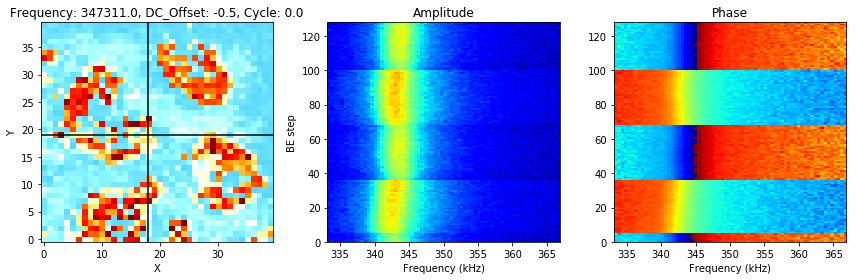

In [4]:
px.be_viz_utils.jupyter_visualize_be_spectrograms(h5_main)

## Fit the Band Excitation (BE) spectra
Fit each of the acquired spectra to a simple harmonic oscillator (SHO) model to extract the following information regarding the response:
* Oscillation amplitude
* Phase
* Resonance frequency
* Quality factor

By default, the cell below will take any previous result instead of re-computing the SHO fit

In [5]:
h5_sho_group = px.hdf_utils.findH5group(h5_main, 'SHO_Fit')
if len(h5_sho_group) == 0:
    print('No SHO fit found. Doing SHO Fitting now')
    sho_fitter = px.BESHOmodel(h5_main, parallel=True)
    sho_fitter.doGuess(strategy='complex_gaussian', processors=max_cores)
    sho_fit_results = sho_fitter.doFit(processors=max_cores)
    h5_sho_guess = sho_fitter.h5_guess
    h5_sho_fit = sho_fitter.h5_fit
else:
    print('Taking previous SHO results already present in file')
    h5_sho_guess = h5_sho_group[-1]['Guess']
    h5_sho_fit = h5_sho_group[-1]['Fit']

Taking previous SHO results already present in file


## Visualize the SHO guess results
Here, we visualize the guess parameters for the SHO fits. BE-line (3D) data is visualized via simple spatial maps of the SHO parameters while more complex BEPS datasets (4+ dimensions) can be visualized using a simple interactive visualizer below. 

Use the sliders below to inspect the BE response at any given location. 

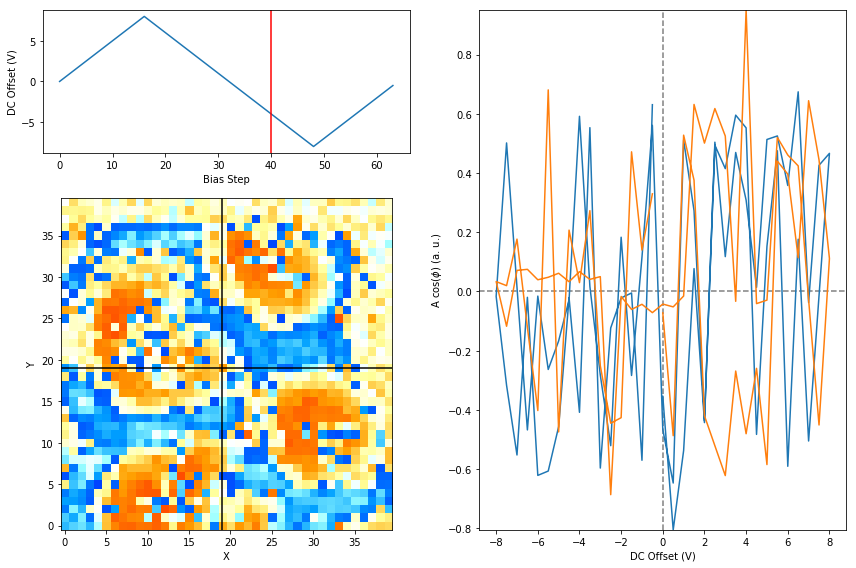

In [7]:
use_viz_function = False
if hdf.file.attrs['data_type'] == 'BELineData' or len(pos_dims) != 2:
    use_viz_function = True
else:
    if h5_main.parent.parent.attrs['VS_mode'] not in ['AC modulation mode with time reversal', 
                                                      'DC modulation mode']:
        use_viz_function = True
    else:
        if h5_main.parent.parent.attrs['VS_mode'] == 'DC modulation mode':
            step_chan = 'DC_Offset'
        else:
            step_chan = 'AC_Amplitude'
if use_viz_function:
    # show plots of SHO guess results vs. applied bias
    px.plot_utils.visualize_sho_results(h5_sho_guess, show_plots=True, 
                                        save_plots=False)
else:
    #sho_guess_collapsed, bias_vec = px.be_viz_utils.get_nd_beps_dset()
    px.be_viz_utils.jupyter_visualize_beps_sho(h5_sho_guess, step_chan)

## Visualize the SHO Fit results

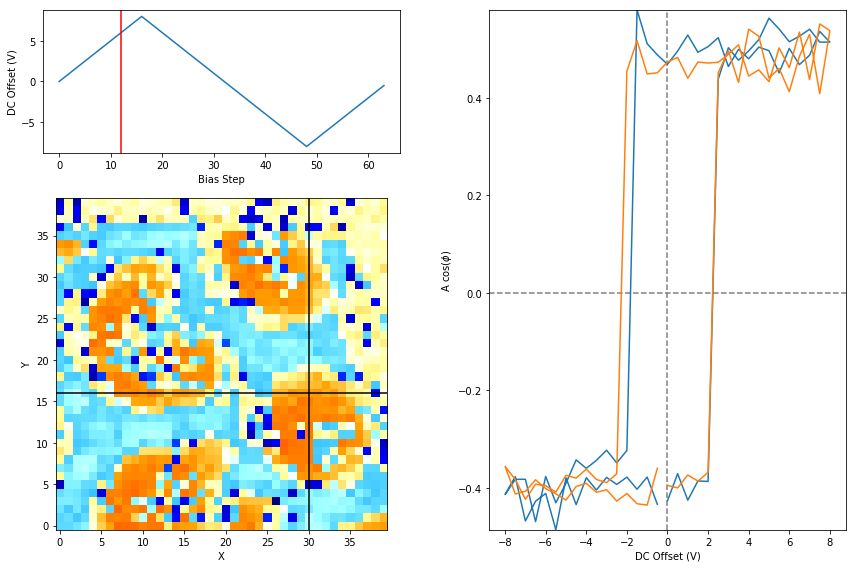

In [13]:
use_viz_function = False
if hdf.file.attrs['data_type'] == 'BELineData' or len(pos_dims) != 2:
    use_viz_function = True
else:
    if h5_main.parent.parent.attrs['VS_mode'] not in ['AC modulation mode with time reversal', 
                                                      'DC modulation mode']:
        use_viz_function = True
    else:
        if h5_main.parent.parent.attrs['VS_mode'] == 'DC modulation mode':
            step_chan = 'DC_Offset'
        else:
            step_chan = 'AC_Amplitude'
if use_viz_function:
    # show plots of SHO guess results vs. applied bias
    px.plot_utils.visualize_sho_results(h5_sho_fit, show_plots=True, 
                                        save_plots=False)
else:
    sho_fit_collapsed, bias_vec = px.be_viz_utils.get_nd_beps_dset(h5_sho_fit, step_chan)
    px.be_viz_utils.jupyter_visualize_beps_sho(sho_fit_collapsed, bias_vec, step_chan, pos_labels, pos_dims)

## Fit loops to a function
This is applicable only to DC voltage spectroscopy datasets from BEPS. The PFM hysteresis loops in this dataset will be projected to maximize the loop area and then fitted to a function.

Note: This computation generally takes a while for reasonably sized datasets.

In [41]:
# Do the Loop Fitting on the SHO Fit dataset

h5_loop_group = px.hdf_utils.findH5group(h5_sho_fit, 'Loop_Fit')
if len(h5_loop_group) == 0:
    print('No loop fits found. Fitting now....')
    loop_fitter = px.BELoopModel(h5_sho_fit, parallel=True)
    h5_loop_guess = loop_fitter.doGuess(processors=max_cores, max_mem=max_mem)
    loop_fitter.doFit(processors=max_cores, max_mem=max_mem)
    h5_loop_fit = h5_loop_guess.parent['Fit']
else:
    print('Taking previously computed loop fits')
    h5_loop_guess = h5_loop_group[-1]['Guess']
    h5_loop_fit = h5_loop_group[-1]['Fit']

Taking previously computed loop fits


## Prepare datasets for visualization

In [42]:
# Prepare some variables for plotting loops fits and guesses
# Plot the Loop Guess and Fit Results
h5_projected_loops = h5_loop_guess.parent['Projected_Loops']
h5_proj_spec_inds = px.hdf_utils.getAuxData(h5_projected_loops, 
                                            auxDataName='Spectroscopic_Indices')[-1]
h5_proj_spec_vals = px.hdf_utils.getAuxData(h5_projected_loops, 
                                            auxDataName='Spectroscopic_Values')[-1]

# reshape the vdc_vec into DC_step by Loop
sort_order = px.hdf_utils.get_sort_order(h5_proj_spec_inds)
dims = px.hdf_utils.get_dimensionality(h5_proj_spec_inds[()], 
                                       sort_order[::-1])
vdc_vec = np.reshape(h5_proj_spec_vals[h5_proj_spec_vals.attrs['DC_Offset']], dims).T

#Also reshape the projected loops to Positions-DC_Step-Loop
# Also reshape the projected loops to Positions-DC_Step-Loop
proj_nd, _ = px.hdf_utils.reshape_to_Ndims(h5_projected_loops)
proj_3d = np.reshape(proj_nd, [h5_projected_loops.shape[0], 
                               proj_nd.shape[2], -1])

## Visualize Loop fits

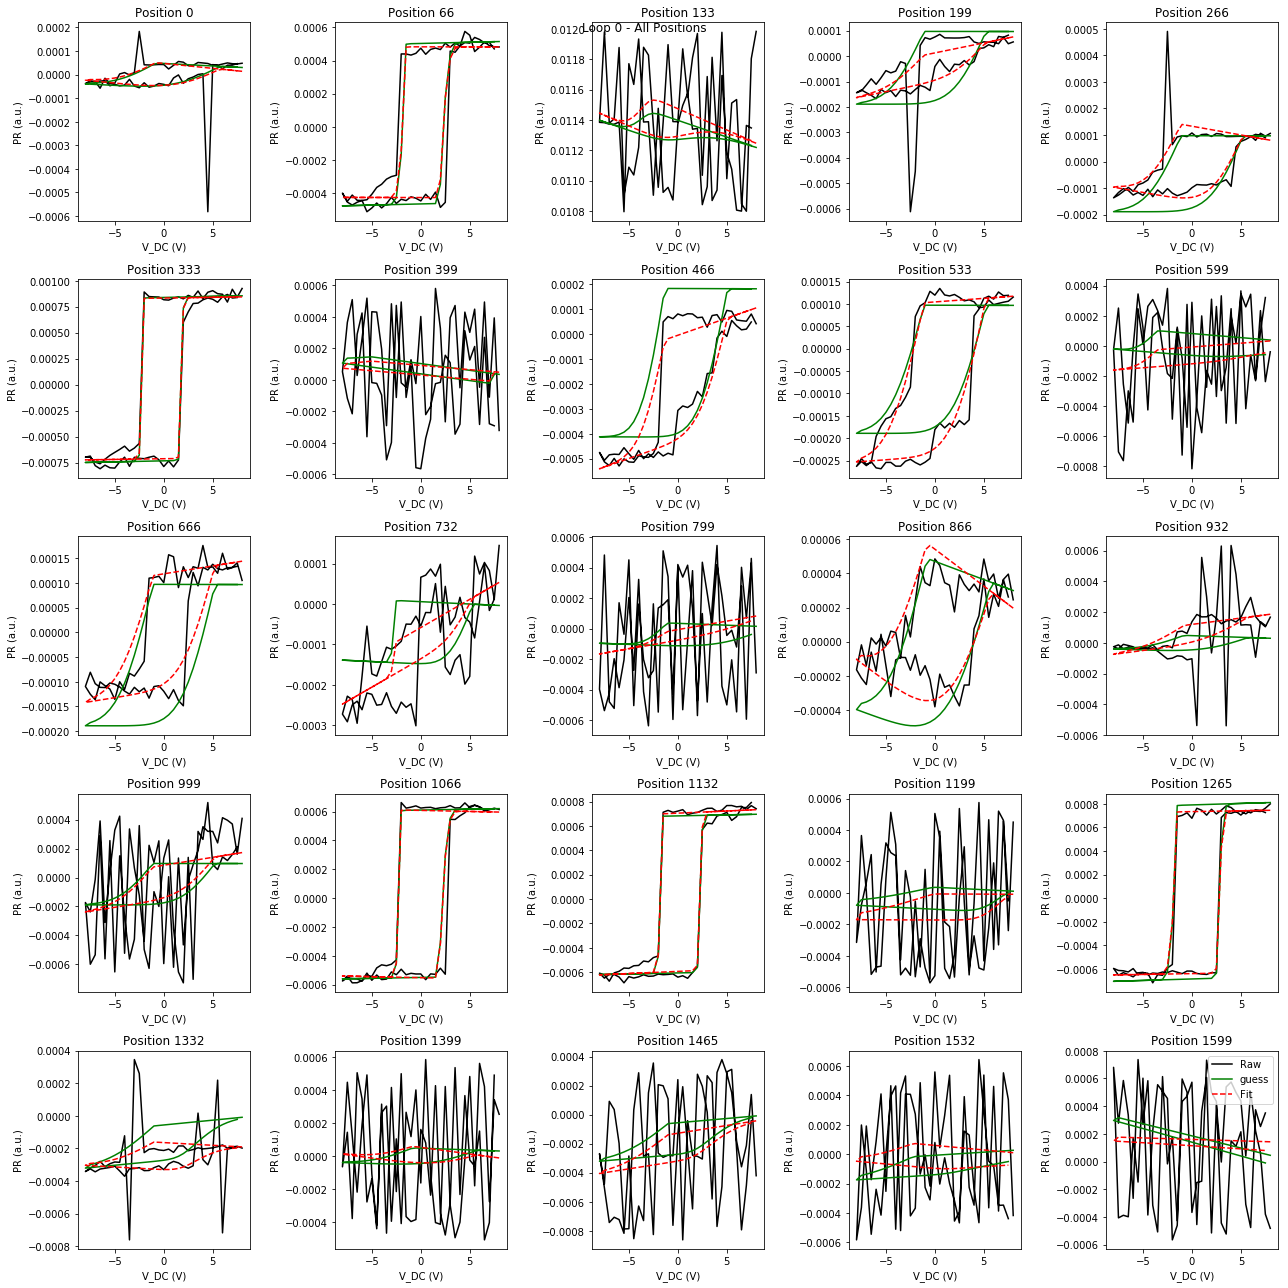

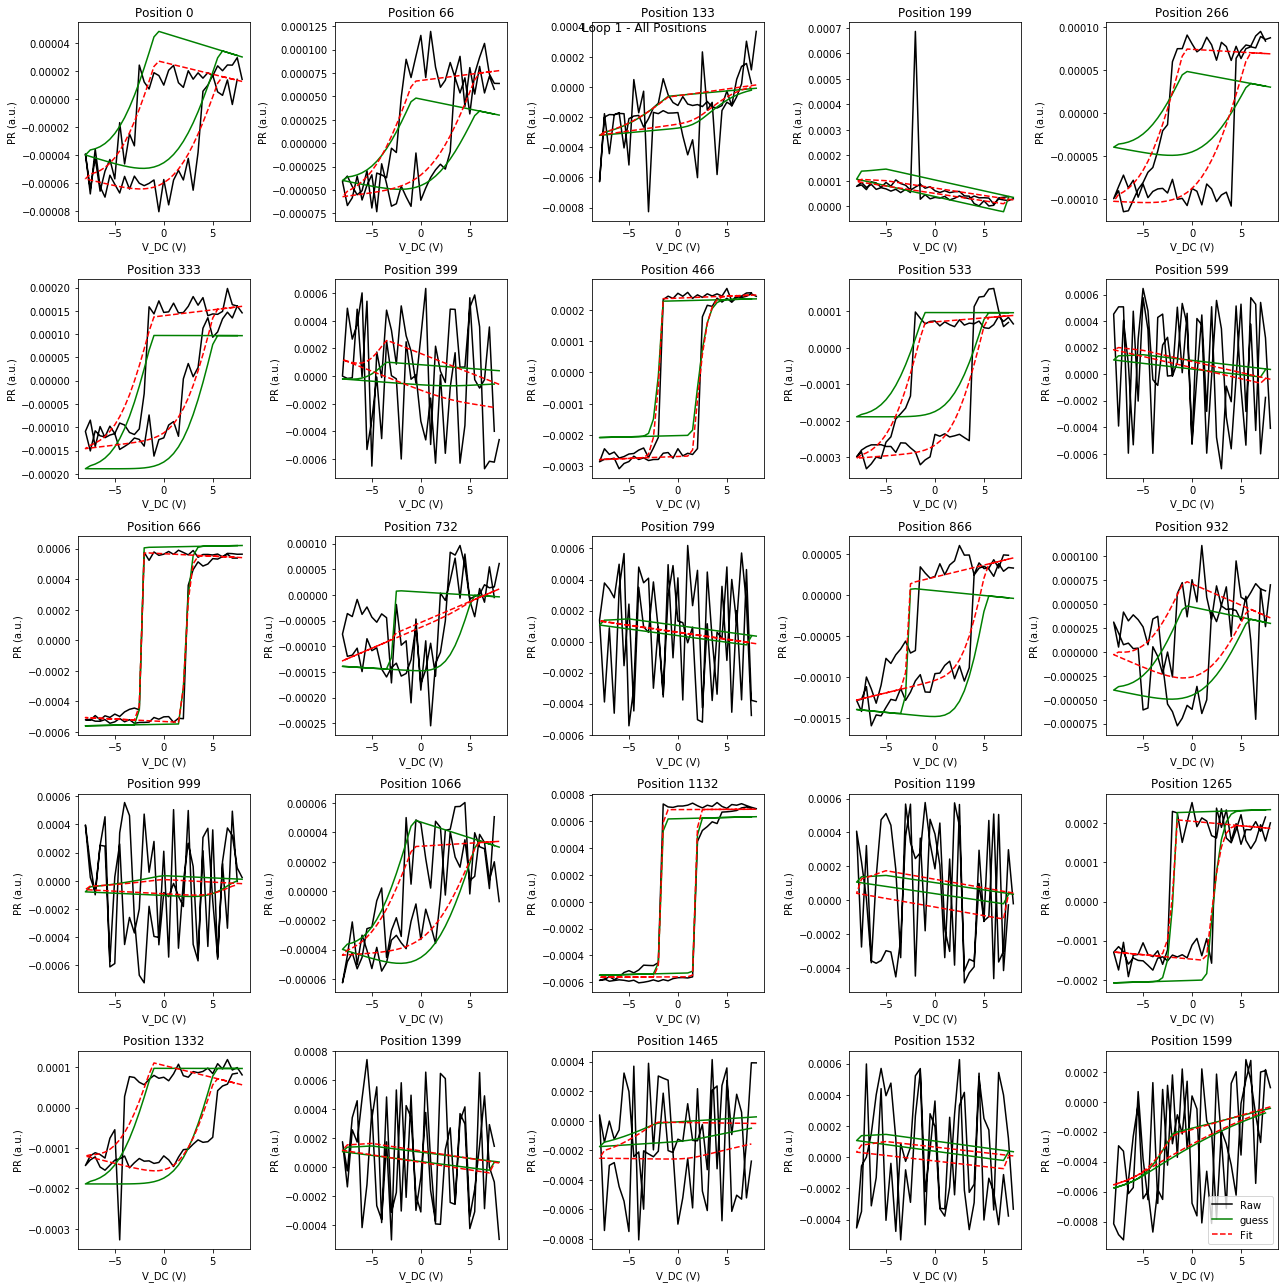

In [43]:
# Plot the loops - Still Need work
for iloop in range(h5_loop_guess.shape[1]):
    fig, ax = px.plot_utils.plot_loop_guess_fit(vdc_vec[:, iloop], proj_3d[:, :, iloop], 
                                  h5_loop_guess[:, iloop], h5_loop_fit[:, iloop],
                                  title='Loop {} - All Positions'.format(iloop))

## Save and close
* Save the .h5 file that we are working on by closing it. <br>
* Also, consider exporting this notebook as a notebook or an html file. <br> To do this, go to File >> Download as >> HTML
* Finally consider saving this notebook if necessary

In [ ]:
hdf.close()